# New Iteration of Image Encoder
---   
Trying new type of loss - this time, only relying on NCE between transformations of the same image to try to get the model to distinguish between those objects.

In [1]:
# Dependencies
import os
import time

import torch
from torch.cuda.amp import GradScaler, autocast


import source as source
import utility_v2 as util_v2
import vision_transformer_v2 as vit_v2
import v2_loader as pcfg_loader


# torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
scaler = GradScaler()   # Train w/ Mixed Precision for faster training

Device: cuda


C:\Users\lucas\AppData\Local\Temp\ipykernel_60448\2751531485.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()   # Train w/ Mixed Precision for faster training


# Defining our Loaders

In [2]:
loader_params = {
    'folder_path': 'data/training',
    'only_inputs': True,
    'percent_mask': 0.1,
    'pad_images': True,
    'transformation_depth': 2,
    'transformation_samples': 4,
    'p_use_base': 0.15,
    'shuffle': True
}

train_params = {
    "epochs": 25,
    "lr": 1e-4,
    "print_frequency": 50,
    "max_eval_iters": None,
    "ema_alpha": 0.01
}

model_params = {
    "max_img_size": 32,
    "unique_patches": 13,
    "embed_dim": 16,
    "depth": 8,
    "num_heads": 2,
    "mlp_ratio": 2,
    "qkv_bias": False,
    "drop_rate": 0.0,
    "attn_drop_rate": 0.0,
    "pos_enc": "Sinusoidal",
    "sinusoidal_theta": 10000,
    "head": False,
    "print_statements": True,
    "output_classes": 13,
    "device": device
}

In [ ]:
def train_iBOT(student_ViT, teacher_ViT, loader_params, train_params, device):
    csv_log_file = util_v2.setup_csv_logger()
    _, train_dataloader = pcfg_loader.get_pcfg_datahandlers(**loader_params)
    optim = torch.optim.AdamW(student_ViT.parameters(), lr=train_params['lr'])
    
    for epoch in range(train_params['epochs']):
        print(f"\nEpoch {epoch + 1}/{train_params['epochs']}")
        print(f"{'Iter':>9} || {'Train Loss':>11} | {'Samples/s':>10}")
        train_loss, last_iter, train_samples = 0, 0, 0
        start_time = time.time()
        
        for i, (ids, u, u_masks, v, v_masks) in enumerate(train_dataloader):
            source.plot_image_and_mask(u[0], u_masks[0])
            return False
            u, u_masks, v, v_masks = u.to(device), u_masks.to(device), v.to(device), v_masks.to(device)
            train_samples += 1
            
            with torch.amp.autocast('cuda'):  # Enable mixed precision
                loss = util_v2.compute_loss(u, u_masks, v, v_masks, student_ViT, teacher_ViT)

            optim.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            
            util_v2.update_teacher_weights(student_ViT, teacher_ViT, train_params['ema_alpha'])
    
            train_loss += loss.cpu().item()
            if (i+1) % train_params['print_frequency'] == 0 or (i+1) == len(train_dataloader):
                iter_count = (i+1) - last_iter
                elapsed_time = time.time() - start_time
                
                train_loss /= iter_count
                samples_per_second = ((iter_count * loader_params['transformation_samples']) / elapsed_time)
                print(f"{(i + 1):>4}/{len(train_dataloader):>4} || {train_loss:>11.3f} | {samples_per_second:>9.2f}")

                last_iter = (i+1)
                start_time = time.time()
                sample_num = train_samples + epoch * len(train_dataloader)
                util_v2.log_to_csv(csv_log_file, sample_num, train_loss, samples_per_second)
                train_loss = 0
        
        # student_ViT.save_model()

Vision Transformer instantiated with 17,296 parameters using Sinusoidal encodings.
Vision Transformer instantiated with 17,296 parameters using Sinusoidal encodings.

Epoch 1/25
     Iter ||  Train Loss |  Samples/s


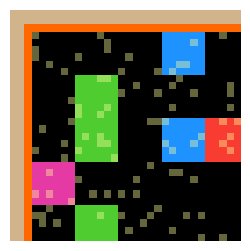

False

In [38]:
# Instantiate and initialize teacher network to match the student
student_ViT = vit_v2.VisionTransformer(**model_params).to(device)
teacher_ViT = vit_v2.VisionTransformer(**model_params).to(device)
teacher_ViT.load_state_dict(student_ViT.state_dict())

# Train model
train_iBOT(student_ViT, teacher_ViT, loader_params, train_params, device)